In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torch.utils.tensorboard import SummaryWriter
import datetime

In [2]:
log_dir = './log/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(
    './data', download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(
    './data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [5]:
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

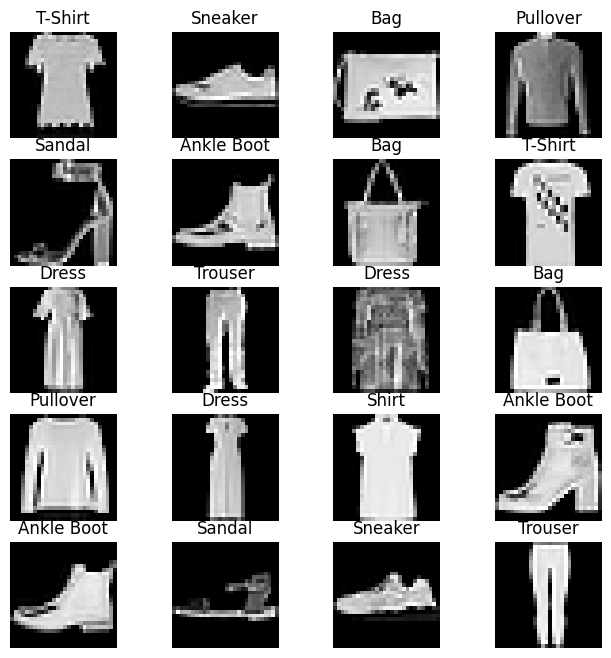

In [6]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal',
              6: 'Shirt',7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [7]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
lr = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
num_epoch = 5
count = 0

for epoch in range(num_epoch):
    for images, labels in train_loader:
        images = images.view(100, 1, 28, 28)
        images.requires_grad_(True)
        
        pred = model(images.to(device))
        loss = criterion(pred, labels.to(device))
        optim.zero_grad()
        loss.backward()
        optim.step()
        count += 1
    
        if count % 50 == 0:
            total = 0
            correct = 0
            for testX, testY in test_loader:
                testX = testX.view(100, 1, 28, 28)
                outputs = model(testX.to(device))
                predictions = torch.max(outputs, dim=1)[1].to(device)
                correct += (predictions == testY.to(device)).sum().item()
                total += len(testY)
                
            
            accuracy = correct / total * 100
            #epoch가 아님!
            writer.add_scalar('Loss(DNN)', loss.item(), count)
            writer.add_scalar('Acc(DNN)', accuracy, count)

        if count % 500 == 0:
            print(f'Iteration: {count}, Loss: {loss.item()}, Accuracy: {accuracy}%')
            

/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.5707929730415344, Accuracy: 83.36%
Iteration: 1000, Loss: 0.38915687799453735, Accuracy: 84.02%
Iteration: 1500, Loss: 0.33490321040153503, Accuracy: 84.32%
Iteration: 2000, Loss: 0.3726061284542084, Accuracy: 85.32%
Iteration: 2500, Loss: 0.27388066053390503, Accuracy: 85.92%
Iteration: 3000, Loss: 0.30032211542129517, Accuracy: 86.38%


In [10]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=64*6*6, out_features=600),
            nn.Dropout2d(0.25),
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.ReLU(),
            nn.Linear(120, 10),
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.layer3(x)
        return x

In [11]:
lr = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): Dropout2d(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=120, bias=True)
    (4): ReLU()
    (5): Linear(in_features=120, out_features=10, bias=True)
  )
)


In [12]:
num_epoch = 5
count = 0

for epoch in range(num_epoch):
    for images, labels in train_loader:
        images = images.view(100, 1, 28, 28)
        images.requires_grad_(True)
        
        pred = model(images.to(device))
        loss = criterion(pred, labels.to(device))
        optim.zero_grad()
        loss.backward()
        optim.step()
        count += 1
        
        if count % 50 == 0:
            total = 0
            corr = 0
            for testX, testY in test_loader:
                testX = testX.view(100, 1, 28, 28)
                outputs = model(testX.to(device))
                predictions = torch.max(outputs, 1)[1].to(device)
                corr += (predictions == testY.to(device)).sum().item()
                total += len(testY)
                
            accuracy = corr / total * 100
            writer.add_scalar('Loss(CNN)', loss.item(), count)
            writer.add_scalar('Acc(CNN)', accuracy, count)
            
        if count % 500 == 0:
            print(f'Iteraion: {count}, Loss: {loss.item()}, Accuracy: {accuracy}%')
        

Iteraion: 500, Loss: 0.43743109703063965, Accuracy: 88.35%
Iteraion: 1000, Loss: 0.34480708837509155, Accuracy: 88.61%
Iteraion: 1500, Loss: 0.22705549001693726, Accuracy: 88.27000000000001%
Iteraion: 2000, Loss: 0.2742844521999359, Accuracy: 90.12%
Iteraion: 2500, Loss: 0.14971953630447388, Accuracy: 90.28%
Iteraion: 3000, Loss: 0.15502028167247772, Accuracy: 90.57%
